In [2]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

In [3]:
role = get_execution_role()
bucket='ds6-yelp-reviews'
data_key = 'review.json'
data_location = 's3://{}/{}'.format(bucket, data_key)

df = pd.read_json(data_location, lines=True)

In [4]:
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ


In [5]:
df.describe()

,cool,funny,stars,useful
count,6.685900e+06,6.685900e+06,6.685900e+06,6.685900e+06
mean,5.787708e-01,4.827667e-01,3.716199e+00,1.354134e+00
std,2.359024e+00,2.378646e+00,1.463643e+00,3.700192e+00
min,-1.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00
25%,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00
75%,1.000000e+00,0.000000e+00,5.000000e+00,2.000000e+00
max,5.060000e+02,1.290000e+03,5.000000e+00,1.241000e+03


In [6]:
len(df[(df['stars'] == 1) | (df['stars'] == 2) | (df['stars'] == 3)])

2283833

In [7]:
len(df[(df['stars'] == 4) | (df['stars'] == 5)])

4402067

In [8]:
2283833/(4402067+2283833)

0.3415894643952198

In [9]:
import seaborn as sns

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


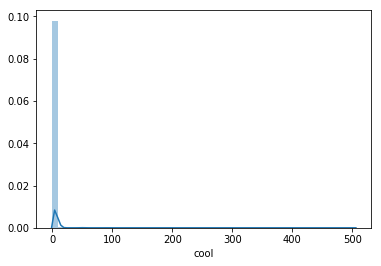

In [10]:
sns.distplot(df['cool'])

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


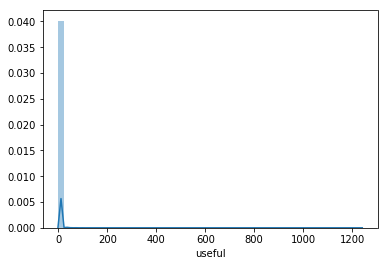

In [11]:
sns.distplot(df['useful'])

In [12]:
from collections import Counter
import gensim
import os
import re
import string

import pandas as pd
import numpy as np

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

In [14]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

In [15]:
nlp = spacy.load("en_core_web_lg")

In [16]:
STOPWORDS = set(STOPWORDS)

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [17]:
df['tokens'] = df['text'].apply(lambda x: tokenize(x))

In [18]:
df['tokens'].head()

0    [total, horrible, service, gs, crooks, actuall...
1    [adore, travis, hard, rock, new, kelly, carden...
2    [office, organized, friendly, dr, phillipp, gr...
3    [went, lunch, steak, sandwich, delicious, caes...
4    [today, second, sessions, paid, session, went,...
Name: tokens, dtype: object

In [19]:
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [20]:
wc = count(df['tokens'])

In [21]:
wc_bad = count(df[df['stars'] <= 3]['tokens'])

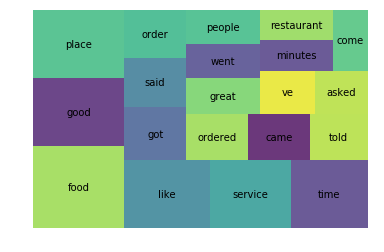

In [22]:
wc_top20_bad = wc_bad[wc_bad['rank'] <= 20]

squarify.plot(sizes=wc_top20_bad['pct_total'], label=wc_top20_bad['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [23]:
wc_good = count(df[df['stars'] >= 4]['tokens'])

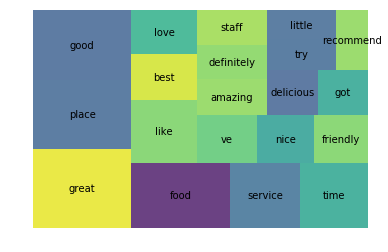

In [24]:
wc_top20_good = wc_good[wc_good['rank'] <= 20]

squarify.plot(sizes=wc_top20_good['pct_total'], label=wc_top20_good['word'], alpha=.8 )
plt.axis('off')
plt.show()